## Classification Models Comparison

In this notebook we will try and compare the performance of various classification models. Following models will be tested and compared - 
 - Logistic Regression
 - Decision Trees
 - Random Forest
 - SVM classifier
 - Naive Bayes
 - Nearest neighbor classifier
 
We will also implement SMOTE technique to balance the imbalanced dataset to improve model performance.

### 1. Import key libraries & read the data

In [31]:
###################################################
# Importing libraries
###################################################

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import pre processesing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# import imbalanced library
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:
###################################################
# Read the data
###################################################

stroke_data = pd.read_csv('data/stroke_data.csv')
print('Number of rows :', stroke_data.shape[0])
print('Number of columns :', stroke_data.shape[1])
stroke_data.head()

Number of rows : 5110
Number of columns : 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Attribute Information

- **id**: unique identifier
- **gender**: "Male", "Female" or "Other"
- **age**: age of the patient
- **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- **ever_married**: "No" or "Yes"
- **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- **Residence_type**: "Rural" or "Urban"
- **avg_glucose_level**: average glucose level in blood
- **bmi**: body mass index
- **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- **stroke**: 1 if the patient had a stroke or 0 if not

**Note: "Unknown" in smoking_status means that the information is unavailable for this patient**

#### We will try to predict if the patient had a stroke or not based on other features available.

In [4]:
###################################################
# Clean the data
###################################################
# explore to see info of the data
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
id                   5110 non-null int64
gender               5110 non-null object
age                  5110 non-null float64
hypertension         5110 non-null int64
heart_disease        5110 non-null int64
ever_married         5110 non-null object
work_type            5110 non-null object
Residence_type       5110 non-null object
avg_glucose_level    5110 non-null float64
bmi                  4909 non-null float64
smoking_status       5110 non-null object
stroke               5110 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 479.1+ KB


In [5]:
for c in stroke_data.columns:
    print('**************************************************')
    print('Column Name - ', c)
    print('Column type - ', stroke_data[c].dtype)
    print('Null values -', stroke_data[c].isnull().sum())
    print('NA Values -', stroke_data[c].isna().sum())
    print('Number of Unique values - ', len(stroke_data[c].unique()))
    print('Unique values - ', stroke_data[c].unique())

**************************************************
Column Name -  id
Column type -  int64
Null values - 0
NA Values - 0
Number of Unique values -  5110
Unique values -  [ 9046 51676 31112 ... 19723 37544 44679]
**************************************************
Column Name -  gender
Column type -  object
Null values - 0
NA Values - 0
Number of Unique values -  3
Unique values -  ['Male' 'Female' 'Other']
**************************************************
Column Name -  age
Column type -  float64
Null values - 0
NA Values - 0
Number of Unique values -  104
Unique values -  [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3

In [6]:
# we see that bmi column has lots of missing values
print('Missing bmi values', np.round(100*len(stroke_data[stroke_data['bmi'].isna()])/len(stroke_data),1),'%')

Missing bmi values 3.9 %


In [7]:
# let's fill up the missing bmi with mean value
bmi_mean = stroke_data.loc[stroke_data['bmi'].notna(),'bmi'].mean()
bmi_median = stroke_data.loc[stroke_data['bmi'].notna(),'bmi'].median()
print('mean -',bmi_mean, 'median -',bmi_median)
stroke_data.loc[stroke_data['bmi'].isna(),'bmi'] = bmi_mean
print('NA Values -', stroke_data['bmi'].isna().sum())

mean - 28.893236911794673 median - 28.1
NA Values - 0


In [8]:
# we also have 'unknown' in smoking_status - lets check how often is that
stroke_data.groupby(by='smoking_status',as_index=False)['id'].count()

,smoking_status,id
0,Unknown,1544
1,formerly smoked,885
2,never smoked,1892
3,smokes,789


since the category of unknown is too big to be replaced with any other value we will leave it be and treat it as a new category itself

### 2. Train the models 

In [9]:
###################################################
# Split data into test and train
###################################################

x = stroke_data.drop(['id','stroke'], axis=1).copy()
y = stroke_data['stroke'].copy()

print('% of positive class in the data :')
print('Had stroke - ', len(y[y==1]))
print('Did not have stroke - ', len(y[y==0]))
print('% of Strokes -', np.round(100*len(y[y==1])/len(y),1),'%')

% of positive class in the data :
Had stroke -  249
Did not have stroke -  4861
% of Strokes - 4.9 %


Only ~5% of the data has positive value for stroke. This is highly imbalanced dataset and might require some correction before training the models. However, let's try the modelling process before we solve it.

In [10]:
# Standadrdize the numeric columns
for c in x.columns:
    if x[c].dtype == 'int64' or x[c].dtype == 'float64':
        x[c] = StandardScaler().fit_transform(x[c].values.reshape(-1,1))
        
# convert string variables to one hot encoding
x = pd.get_dummies(x)

#split 80-20 training vs test data
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8, random_state=1234)

print('Rows in x :', len(x))
print('Rows in train :', len(x_train))
print('Rows in test :', len(x_test))
x_train.head()

Rows in x : 5110
Rows in train : 4088
Rows in test : 1022


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2332,1.139889,-0.328602,4.185032,2.035868,1.793723,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4347,-0.584978,-0.328602,-0.238947,-0.388428,2.131506,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3156,-0.629206,-0.328602,-0.238947,-0.817765,-0.271946,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
1564,-0.806115,-0.328602,-0.238947,-0.825274,3.404685,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
12,0.476478,-0.328602,-0.238947,-0.036168,-0.206987,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1


********************************************************
Model name : Logistic Reg


/Users/Akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


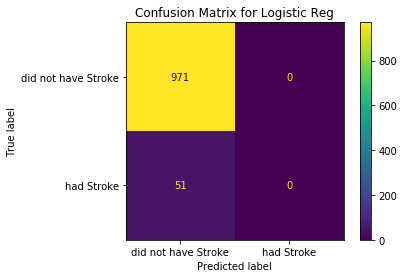

/Users/Akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


********************************************************
********************************************************
Model name : Decision Tree


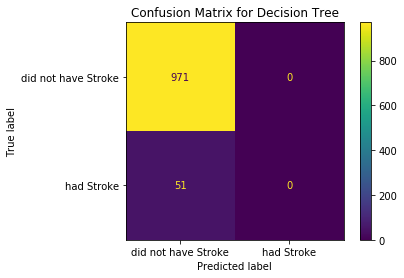

********************************************************
********************************************************
Model name : Random Forest


/Users/Akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


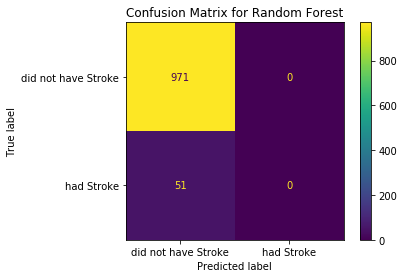

********************************************************
********************************************************
Model name : Linear SVM


/Users/Akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


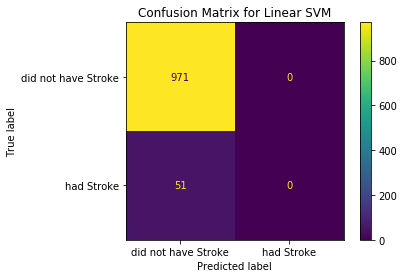

********************************************************


/Users/Akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


********************************************************
Model name : RBF SVM


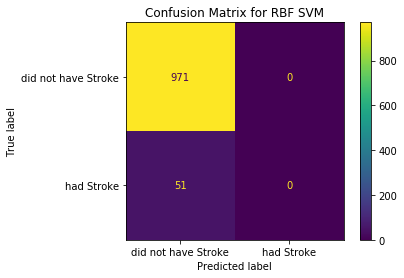

********************************************************
********************************************************
Model name : Naive Bayes


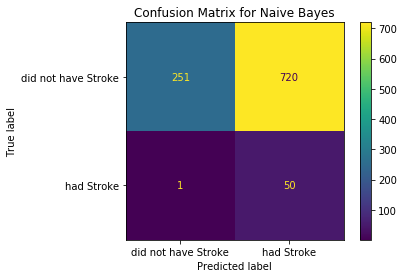

********************************************************
********************************************************
Model name : Nearest Neighbors


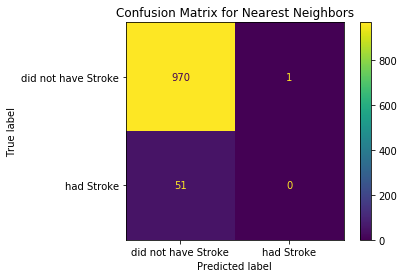

********************************************************


In [49]:
###################################################
# Train the models
###################################################

model_names = ["Logistic Reg", "Decision Tree", "Random Forest", "Linear SVM", "RBF SVM",\
               "Naive Bayes", "Nearest Neighbors"]

model_param = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5, random_state=123),
    RandomForestClassifier(max_depth=10, n_estimators=20, max_features=1, random_state=123),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianNB(),
    KNeighborsClassifier(10)]

model_compare = pd.DataFrame(columns=['model_name', 'true_neg', 'false_pos', 'false_neg', 'true_pos',\
                 'precision', 'recall', 'accuracy', 'f_score'])

rn = 0

for name, model in zip(model_names, model_param):
    cl_model = model.fit(x_train, y_train)
    
    y_pred = cl_model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    prec = np.round(tp/(tp+fp),2)
    rec = np.round(tp/(tp+fn),2)
    acc = np.round((tp+tn)/(tp+tn+fp+fn),2)
    fscore = np.round(f1_score(y_test, y_pred),2)
    
    temp = [name, tn, fp, fn, tp, prec, rec, acc, fscore]
    model_compare.loc[rn] = temp
    rn = rn + 1
    
    print('********************************************************')
    print('Model name :', name)
    plot_confusion_matrix(cl_model, x_test, y_test, display_labels=['did not have Stroke', 'had Stroke'])
    plt.title('Confusion Matrix for '+str(name))
    plt.show()
    print('********************************************************')

In [50]:
# see the comparison table
model_compare

,model_name,true_neg,false_pos,false_neg,true_pos,precision,recall,accuracy,f_score
0,Logistic Reg,971,0,51,0,NaN,0.00,0.95,0.00
1,Decision Tree,971,0,51,0,NaN,0.00,0.95,0.00
2,Random Forest,971,0,51,0,NaN,0.00,0.95,0.00
3,Linear SVM,971,0,51,0,NaN,0.00,0.95,0.00
4,RBF SVM,971,0,51,0,NaN,0.00,0.95,0.00
5,Naive Bayes,251,720,1,50,0.06,0.98,0.29,0.12
6,Nearest Neighbors,970,1,51,0,0.00,0.00,0.95,0.00


Clearly the models are not predicting positive class (stroke = 1) effectively enough as most of them have 0 precision and recall values.

We need to improve our prediction by improving upon the imbalance in the data

### 3. Oversampling the minority class - SMOTE 

SMOTE (**Synthetic Minority Oversampling TEchnique**) is widely used approach to synthesizing new examples. The original paper on SMOTE is [here](https://arxiv.org/abs/1106.1813) and the details of implementation can be found here - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

We will use this technique to up sample the positive stroke class and then train the models.

The correct application of oversampling is to apply the method to the training dataset only, then evaluate the model on the non-transformed test set.

As mentioned in the paper, it is believed that SMOTE (over sampling) performs better when combined with undersampling of the majority class, such as random undersampling. We can achieve this by simply adding a RandomUnderSampler step to the Pipeline.

We will first oversample the minority class with SMOTE to about ~20% (currently it is 5%), then undersample the majority class to achieve about a 1:2 ratio.

In [42]:
###################################################
# apply the sampling transformation on the training data
###################################################

# define pipeline
# here sampling_strategy is defined as : (# sample of minority) / (# samples of majority)
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

x_train_sm, y_train_sm = pipeline.fit_resample(x_train, y_train)

print('**********************************************************')
print('Before sampling - ')
print('Shape of x train :', x_train.shape)
print('Shape of y train :', y_train.shape)
print('% of positives of all -', np.round(100*len(y_train[y_train==1])/len(y_train),1),'%')
print('% of positives of negatives -', \
      np.round(100*len(y_train[y_train==1])/len(y_train[y_train==0]),1),'%')
print('**********************************************************')
print('After sampling - ')
print('Shape of x train :', x_train_sm.shape)
print('Shape of y train :', y_train_sm.shape)
print('% of positives -', np.round(100*len(y_train_sm[y_train_sm==1])/len(y_train_sm),1),'%')
print('% of positives of negatives -', \
      np.round(100*len(y_train_sm[y_train_sm==1])/len(y_train_sm[y_train_sm==0]),1),'%')

**********************************************************
Before sampling - 
Shape of x train : (4088, 21)
Shape of y train : (4088,)
% of positives of all - 4.8 %
% of positives of negatives - 5.1 %
**********************************************************
After sampling - 
Shape of x train : (2334, 21)
Shape of y train : (2334,)
% of positives - 33.3 %
% of positives of negatives - 50.0 %


********************************************************
Model name : Logistic Reg


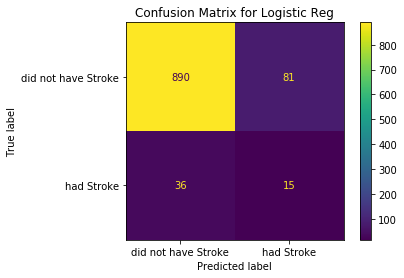

********************************************************
********************************************************
Model name : Decision Tree


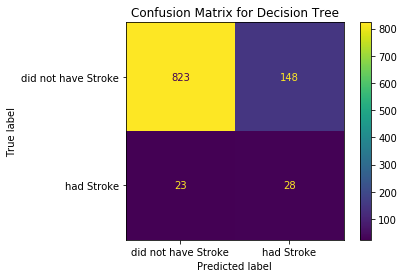

********************************************************
********************************************************
Model name : Random Forest


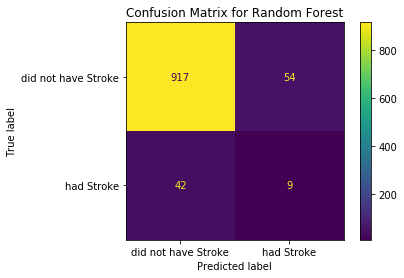

********************************************************
********************************************************
Model name : Linear SVM


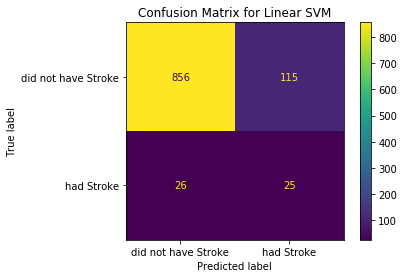

********************************************************
********************************************************
Model name : RBF SVM


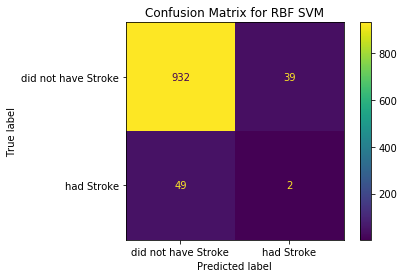

********************************************************
********************************************************
Model name : Naive Bayes


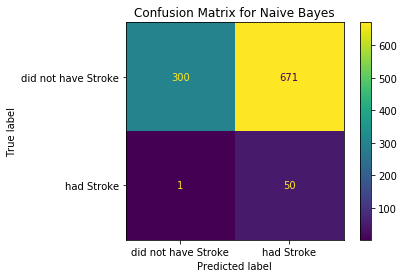

********************************************************
********************************************************
Model name : Nearest Neighbors


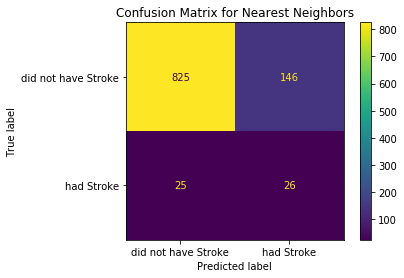

********************************************************


In [51]:
###################################################
# Train the models after over sampling training data
###################################################

model_names = ["Logistic Reg", "Decision Tree", "Random Forest", "Linear SVM", "RBF SVM",\
               "Naive Bayes", "Nearest Neighbors"]

model_param = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5, random_state=123),
    RandomForestClassifier(max_depth=10, n_estimators=20, max_features=1, random_state=123),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianNB(),
    KNeighborsClassifier(10)]

model_compare_sm = pd.DataFrame(columns=['model_name', 'true_neg', 'false_pos', 'false_neg', 'true_pos',\
                 'precision', 'recall', 'accuracy', 'f_score'])

rn = 0

for name, model in zip(model_names, model_param):
    
    cl_model = model.fit(x_train_sm, y_train_sm)
    
    y_pred = cl_model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    prec = np.round(tp/(tp+fp),2)
    rec = np.round(tp/(tp+fn),2)
    acc = np.round((tp+tn)/(tp+tn+fp+fn),2)
    fscore = np.round(f1_score(y_test, y_pred),2)
    
    temp = [name, tn, fp, fn, tp, prec, rec, acc, fscore]
    model_compare_sm.loc[rn] = temp
    rn = rn + 1
    
    print('********************************************************')
    print('Model name :', name)
    plot_confusion_matrix(cl_model, x_test, y_test, display_labels=['did not have Stroke', 'had Stroke'])
    plt.title('Confusion Matrix for '+str(name))
    plt.show()
    print('********************************************************')

In [52]:
# show the model comparison table
model_compare_sm

,model_name,true_neg,false_pos,false_neg,true_pos,precision,recall,accuracy,f_score
0,Logistic Reg,890,81,36,15,0.16,0.29,0.89,0.20
1,Decision Tree,823,148,23,28,0.16,0.55,0.83,0.25
2,Random Forest,917,54,42,9,0.14,0.18,0.91,0.16
3,Linear SVM,856,115,26,25,0.18,0.49,0.86,0.26
4,RBF SVM,932,39,49,2,0.05,0.04,0.91,0.04
5,Naive Bayes,300,671,1,50,0.07,0.98,0.34,0.13
6,Nearest Neighbors,825,146,25,26,0.15,0.51,0.83,0.23


We now see that the models are performing much better on test dataset than before and capturing postive classes much better as seen from precision and recall values!!

The top model performers are - **DecisionTree, Linear SVM and KNN** (based on precision , recall and f scores).

As next steps - 
- we can try fine tuning the parameters of the models to improve performance
- we can try various other combinations of oversampling to improve performance